# Face Recognition Applied Math Project
### Mohamed Ali (MSCV) and Elizaveta Genke (MAIA)

In [402]:
#Import necessary libraries
import numpy as np
import pandas as pd
import glob, os
import matplotlib.pylab as plt
import re

from skimage import transform as tf
from skimage import data
from skimage import io


from skimage import  io

import numpy as np
import matplotlib.pylab as plt
import seaborn as sns
from skimage import io
from skimage import transform as tf
from skimage import data, color
from skimage.transform import rescale, resize
import pandas as pd
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
%matplotlib inline


Open all .txt files in the folder and save coordinates of face features (right eye, left eye, nose tip, right mouth corner, left mouth corner) to an array (tabular data structure from pandas library). Sort this array in alphabetical order using names.

In [403]:
files = glob.glob("./Train set/*.txt")
L = []
names =[]
for i in range(len(files)):
    x = np.loadtxt(files[i]).flatten()
    names.append(files[i].strip('./txt'))
    output = np.hstack(x)
    L.append(output)
    output = np.array(L)
    df = pd.DataFrame(output,index=names)
    
columns = pd.MultiIndex.from_product([['Right eye', 'Left eye', 'Nose tip', 'Right mouth corner' , 'Left mouth corner']
                                      , ['X', 'Y']],
names=['Feature', 'Position '])

df.columns=columns
df = df.sort_index()


Let's plot all the facial feature positions in one plot:

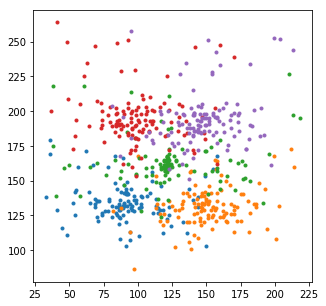

In [404]:
plt.figure(figsize=(5,5))
plt.plot(output[:,0::2],output[:,1::2],'.');

Create an array of predefined feature positions in a 64x64 window.

In [405]:
src = np.array([[13, 20], [50, 20], [34, 34], [16, 50], [48, 50]])

Define functions to open image as grey and to estimate transformation (using AffineTransform function).

In [406]:
def GetImg(file):
    img = io.imread(file,as_grey=True)
    return img

In [407]:
def TransForm(src,dst):
    tform3 = tf.AffineTransform()
    tform3.estimate(src, dst)
    return tform3.params   

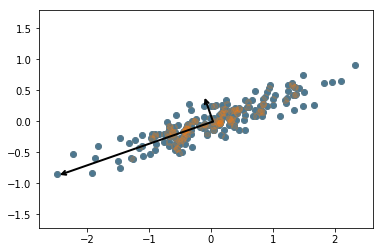

In [408]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
pca.fit(X)

rng = np.random.RandomState(1)
X = np.dot(rng.rand(2, 2), rng.randn(2, 200)).T
plt.scatter(X[:, 0], X[:, 1])
plt.axis('equal');


def draw_vector(v0, v1, ax=None):
    ax = ax or plt.gca()
    arrowprops=dict(arrowstyle='->',
                    linewidth=2,
                    shrinkA=0, shrinkB=0)
    ax.annotate('', v1, v0, arrowprops=arrowprops)
    
    
plt.scatter(X[:, 0], X[:, 1], alpha=0.2)
for length, vector in zip(pca.explained_variance_, pca.components_):
    v = vector * 3 * np.sqrt(length)
    draw_vector(pca.mean_, pca.mean_ + v)
plt.axis('equal');

Load all images and sort them.

In [409]:
import os

Imgfiles = sorted(glob.glob("./Train set/*.jpg"))
files = sorted(glob.glob("./Train set/*.txt"))


Estimate Affine transform of every image facial features to predefined positions in a 64x64 window. Apply this transform to every pixel and save this to '/warped' folder.

In [410]:
for i in range(len(Imgfiles)):
    img = GetImg(Imgfiles[i])
    x = np.loadtxt(files[i]).flatten()
    x = x.reshape(5,2) 
    para = TransForm(src,x)  
    warped = tf.warp( img, para, output_shape=(64,64))
    io.imsave('./Trainwarped/{}.jpg'.format(Imgfiles[i].strip('./Train set /jpg ')),warped)
len(Imgfiles)

/home/eljazri/anaconda3/lib/python3.6/site-packages/skimage/util/dtype.py:122: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


120

Define function that converts image into a vector in d-dimensional space (d=64x64=4096). Load a collection of image files as vectors and concatenate all images in the image collection into an array.

In [411]:
def flatten(img):
    out=io.imread(img,as_grey=True).flatten()
    return out

Train_warped_Images = sorted(glob.glob("Trainwarped/*.jpg"))
Train_warped_Collection = io.ImageCollection(Train_warped_Images,load_func=flatten)
stack = io.concatenate_images(Train_warped_Collection)
len(stack)

120

Calculate mean vector and compute covariance matrix of "centralised" matrix of images using the formula below:
\begin{equation}
 \Sigma = \frac{1}{p-1} D^T D 
\end{equation}



[  85.46666667   86.375        86.18333333 ...,  104.65        104.575
  105.96666667]
(4096, 4096)


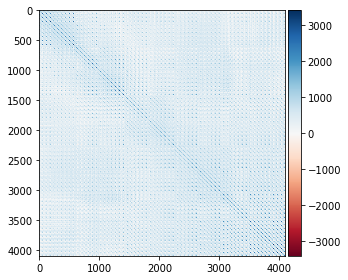

In [412]:
mean_vec = np.mean(stack,axis=0)
print(mean_vec)
cov_mat = (stack - mean_vec).T.dot((stack - mean_vec)) / (stack.shape[0]-1)
print(cov_mat.shape)
io.imshow(cov_mat);

Let's show mean image with points corresponding to predefined positions of facial features over it.

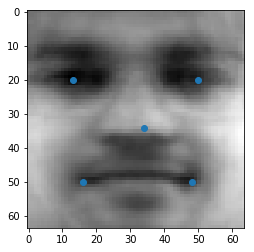

In [413]:
mean_Face = mean_vec.reshape(64,64) 
plt.imshow(mean_Face,cmap='gray')
plt.scatter(x=[13, 50, 34, 16, 48], y=[20, 20, 34, 50, 50])
plt.show()

Then we compute eigenvalues and eigenvectors of the covariance matrix.

In [414]:
eig_vals, eig_vecs = np.linalg.eig(cov_mat)

print('Eigenvectors \n%s' %eig_vecs)
print('\nEigenvalues \n%s' %eig_vals)

Eigenvectors 
[[ -1.32497093e-02+0.j   1.69549762e-02+0.j   2.45178169e-02+0.j ...,
   -1.89290066e-03+0.j   2.57736556e-08+0.j   7.58941149e-05+0.j]
 [ -1.31518583e-02+0.j   1.78100913e-02+0.j   2.67100880e-02+0.j ...,
   -6.73125517e-05+0.j   9.97834067e-05+0.j  -7.89714111e-05+0.j]
 [ -1.30925233e-02+0.j   1.66587634e-02+0.j   3.02304735e-02+0.j ...,
    6.45506809e-05+0.j  -7.56907153e-05+0.j   7.66276590e-05+0.j]
 ..., 
 [ -1.60092899e-02+0.j  -3.29618430e-02+0.j  -9.96878533e-03+0.j ...,
    1.82036466e-02+0.j   1.10158141e-02+0.j   2.13832278e-02+0.j]
 [ -1.52705690e-02+0.j  -3.31556775e-02+0.j  -1.05553722e-02+0.j ...,
   -9.94579580e-03+0.j   1.85109914e-02+0.j  -1.37589978e-02+0.j]
 [ -1.51855652e-02+0.j  -3.36113466e-02+0.j  -1.11617834e-02+0.j ...,
    1.18215647e-02+0.j   1.29349178e-02+0.j  -1.76963443e-02+0.j]]

Eigenvalues 
[  1.88329830e+06+0.j   8.07622218e+05+0.j   3.07908689e+05+0.j ...,
   7.12455653e-14+0.j  -1.94058477e-13+0.j   6.27602409e-13+0.j]


After this we choose 100 eigenvectors corresponding to the highest eigenvalues and create an array out of them (Ф projection matrix).

In [415]:
# Make a list of (eigenvalue, eigenvector) tuples
eig_pairs = [(np.abs(eig_vals[i]), eig_vecs[:,i]) for i in range(len(eig_vals))]

# Sort the (eigenvalue, eigenvector) tuples from high to low
def getKey(item):
    return item[0]
eig_pairs = sorted(eig_pairs, key=getKey,reverse=True) 
eig_pairs = eig_pairs[0:100]

In [416]:
L=[]
for i in eig_pairs:
    L.append(i[1])
EigVecs = np.array(L)

Then we create a matrix of every image feature vectors. This feature vectors we get by projecting every image into a PCA space by using formula:
\begin{equation}
\phi_i=X_iФ
\end{equation}

In [417]:
Feature = []

for i in range(len(images)):
    Feature.append(images[i].dot(np.real(EigVecs).T))
    
Feature = np.array(Feature)
Feature.shape

(120, 100)

We create extract names for images in train and test set.

In [418]:
TestImgfiles = sorted(glob.glob("./Test set/*.jpg"))
Testfiles = sorted(glob.glob("./Test set/*.txt"))

for i in range(len(TestImgfiles)):
    img = GetImg(TestImgfiles[i])
    x = np.loadtxt(Testfiles[i]).flatten()
    x = x.reshape(5,2) 
    para = TransForm(src,x)  
    warped = tf.warp( img, para, output_shape=(64,64))
    io.imsave('./Testwarped/{}.jpg'.format(TestImgfiles[i].strip('./Train set /jpg ')),warped)
len(TestImgfiles)

/home/eljazri/anaconda3/lib/python3.6/site-packages/skimage/util/dtype.py:122: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


80

In [419]:
train_names=sorted(glob.glob("Train set/*.txt"))
labels_train=[]
for i in range (len(images)):
    filename_w_ext = os.path.basename(train_names[i])
    filename, file_extension = os.path.splitext(filename_w_ext)
    labels_train.append(re.sub(r'\d+', '', filename))
labels_train = np.array(labels_train)
print (labels_train)

['Ali' 'Ali' 'Ali' 'Alyafi_' 'Alyafi_' 'Alyafi_' 'Anaghan' 'Anaghan'
 'Anaghan' 'Asraf Ali_' 'Asraf Ali_' 'Asraf Ali_' 'Birhanu' 'Birhanu'
 'Birhanu' 'Boudissa' 'Boudissa' 'Boudissa' 'Doiriel' 'Doiriel' 'Doiriel'
 'Dudhagara' 'Dudhagara' 'Dudhagara' 'Fahad' 'Fahad' 'Fahad' 'Flavien'
 'Flavien' 'Flavien' 'Genke' 'Genke' 'Genke' 'Hasan' 'Hasan' 'Hasan'
 'Herrera_' 'Herrera_' 'Herrera_' 'KB' 'KB' 'KB' 'Kozynets' 'Kozynets'
 'Kozynets' 'Malav' 'Malav' 'Malav' 'Mohammed Abdul' 'Mohammed Abdul'
 'Mohammed Abdul' 'Ngige' 'Ngige' 'Ngige' 'Pandey' 'Pandey' 'Pandey'
 'Rakic' 'Rakic' 'Rakic' 'Reimmer' 'Reimmer' 'Reimmer' 'Shah' 'Shah' 'Shah'
 'Sonizara' 'Sonizara' 'Sonizara' 'Sulaiman_' 'Sulaiman_' 'Sulaiman_'
 'Vaishnav' 'Vaishnav' 'Vaishnav' 'Yawson' 'Yawson' 'Yawson' 'antoine'
 'antoine' 'antoine' 'benali' 'benali' 'benali' 'berada' 'berada' 'berada'
 'brianna' 'brianna' 'brianna' 'gulnur' 'gulnur' 'gulnur' 'khan' 'khan'
 'khan' 'lav' 'lav' 'lav' 'ochoa' 'ochoa' 'ochoa' 'rockenbach' 'rockenbac

In [420]:
test_names=sorted(glob.glob("Test set/*.txt"))
labels_test=[]
for i in range (len(test_names)):
    filename_w_ext = os.path.basename(test_names[i])
    filename, file_extension = os.path.splitext(filename_w_ext)
    labels_test.append(re.sub(r'\d+', '', filename))
labels_test = np.array(labels_test)
print (labels_test)

['Ali' 'Ali' 'Alyafi_' 'Alyafi_' 'Anaghan' 'Anaghan' 'Asraf Ali_'
 'Asraf Ali_' 'Birhanu' 'Birhanu' 'Boudissa' 'Boudissa' 'Doiriel' 'Doiriel'
 'Dudhagara' 'Dudhagara' 'Fahad' 'Fahad' 'Flavien' 'Flavien' 'Genke'
 'Genke' 'Hasan' 'Hasan' 'Herrera_' 'Herrera_' 'KB' 'KB' 'Kozynets'
 'Kozynets' 'Malav' 'Malav' 'Mohammed Abdul' 'Mohammed Abdul' 'Ngige'
 'Ngige' 'Pandey' 'Pandey' 'Rakic' 'Rakic' 'Reimmer' 'Reimmer' 'Sonizara'
 'Sonizara' 'Sulaiman_' 'Sulaiman_' 'Vaishnav' 'Vaishnav' 'Yawson' 'Yawson'
 'antoine' 'antoine' 'benali' 'benali' 'berada' 'berada' 'brianna'
 'brianna' 'gulnur' 'gulnur' 'khan' 'khan' 'lav' 'lav' 'ochoa' 'ochoa'
 'rockenbach' 'rockenbach' 'roger' 'roger' 'shah' 'shah' 'toshpulatov'
 'toshpulatov' 'tushar' 'tushar' 'valencia' 'valencia' 'zotova' 'zotova']


Then we start testing our face recognition system. For every image from training set we calculate feature vector

In [648]:
from numpy.linalg import norm
epsilon = 0

position1 = np.zeros((1,1),dtype=np.float128)
position2 = np.zeros((1,1),dtype=np.int64)
position3 = np.zeros((1,1),dtype=np.int64)

Testwarpedfiles = sorted(glob.glob("./Testwarped/*.jpg"))

test_images = io.ImageCollection('Testwarped/*.jpg',load_func=flatten) # change the test image dim and color 
for i in range (len(test_images)):
    
    test_feature=test_images[i].dot(np.real(EigVecs).T)
    distance=norm(Feature-test_feature, axis=1, ord=2) 
    
    #position = np.where(distance == distance.min())
    sortD = np.sort(distance)
    
    #print(first_match,position,sortD[0])
    
    position1 = np.where(distance == sortD[0])
    position2 = np.where(distance == sortD[1])
    position3 = np.where(distance == sortD[2])
    position4 = np.where(distance == sortD[3])
    position5 = np.where(distance == sortD[4])
    
    

    
   
    
    
    print(labels_test[i], ' : First match as --> ',labels_train[position1[0].item()],
          ' : Second match as --> ',labels_train[position2[0].item()]  ,
          ' : Third match as --> ',labels_train[position3[0].item()] , 
          ' : Fourth match as --> ',labels_train[position4[0].item()]  ,
          ' : Fifth match as --> ',labels_train[position5[0].item()]  ,
         )
    if (labels_test[i]   != (labels_train[position1[0].item()]) and 
        labels_test[i]   != (labels_train[position2[0].item()]) and 
        labels_test[i]   != (labels_train[position3[0].item()]) and 
        labels_test[i]   != (labels_train[position4[0].item()]) and 
        labels_test[i]   != (labels_train[position5[0].item()])):
                           
                          
        epsilon = epsilon + 1
    
    
print ('The accuracy is', 1-epsilon/(len(test_images))) 



Ali  : First match as -->  Ali  : Second match as -->  Hasan  : Third match as -->  Ali  : Fourth match as -->  Birhanu  : Fifth match as -->  Rakic  : Sixth match as -->  Sonizara  : Seventh match as -->  Ngige
Ali  : First match as -->  Ali  : Second match as -->  Birhanu  : Third match as -->  Hasan  : Fourth match as -->  Mohammed Abdul  : Fifth match as -->  Mohammed Abdul  : Sixth match as -->  rockenbach  : Seventh match as -->  Ngige
Alyafi_  : First match as -->  Alyafi_  : Second match as -->  Hasan  : Third match as -->  Alyafi_  : Fourth match as -->  Ali  : Fifth match as -->  Ali  : Sixth match as -->  Sonizara  : Seventh match as -->  khan
Alyafi_  : First match as -->  Mohammed Abdul  : Second match as -->  Mohammed Abdul  : Third match as -->  Hasan  : Fourth match as -->  roger  : Fifth match as -->  Vaishnav  : Sixth match as -->  Asraf Ali_  : Seventh match as -->  benali
Anaghan  : First match as -->  Anaghan  : Second match as -->  Anaghan  : Third match as -->  P

antoine  : First match as -->  Boudissa  : Second match as -->  KB  : Third match as -->  tushar  : Fourth match as -->  tushar  : Fifth match as -->  Boudissa  : Sixth match as -->  KB  : Seventh match as -->  Reimmer
benali  : First match as -->  antoine  : Second match as -->  KB  : Third match as -->  KB  : Fourth match as -->  Fahad  : Fifth match as -->  Boudissa  : Sixth match as -->  tushar  : Seventh match as -->  KB
benali  : First match as -->  KB  : Second match as -->  Boudissa  : Third match as -->  tushar  : Fourth match as -->  tushar  : Fifth match as -->  KB  : Sixth match as -->  Yawson  : Seventh match as -->  Genke
berada  : First match as -->  roger  : Second match as -->  tushar  : Third match as -->  Boudissa  : Fourth match as -->  Pandey  : Fifth match as -->  Dudhagara  : Sixth match as -->  tushar  : Seventh match as -->  Anaghan
berada  : First match as -->  roger  : Second match as -->  Boudissa  : Third match as -->  zotova  : Fourth match as -->  tushar 

In [634]:
def compare(*images, **kwargs):
    """
    Utility function to display images side by side.
    
    Parameters
    ----------
    image0, image1, image2, ... : ndarrray
        Images to display.
    labels : list
        Labels for the different images.
    """
    f, axes = plt.subplots(1, len(images), **kwargs)
    axes = np.array(axes, ndmin=1)
    
    labels = kwargs.pop('labels', None)
    if labels is None:
        labels = [''] * len(images)
    
    for n, (image, label) in enumerate(zip(images, labels)):
        axes[n].imshow(image, interpolation='nearest', cmap='gray')
        axes[n].set_title(label)
        axes[n].axis('off')
    
    f.tight_layout()

In [642]:
def applyPCA(image,apply,k=5):
   
    
    test_feature=GetImg(image).flatten().dot(np.real(EigVecs).T)
    f, axes = plt.subplots()
    axes.imshow(GetImg(image),cmap='gray')
    
    distance=norm(Feature-test_feature, axis=1, ord=2) 
    sortD = np.sort(distance)
    pose =[]
    position = []
    
    for i in sortD[0:k]:
        pose.append(i)
        position.append(np.where(distance == i)[0].item())
    index = np.array(position)
    if(apply):
        print('Match found in position : ',index)
        
        for i in index:
            compare(GetImg(Imgfiles[i]))
    



In [649]:
interact(applyPCA, image = widgets.Dropdown(options=Testwarpedfiles,description='Image Name:'),
        apply = widgets.ToggleButton(
    value=False,
    description='Test PCA ',
    disabled=False,
    tooltip='Description',
    icon='check'
)
         
        );

interactive(children=(Dropdown(description='Image Name:', options=('./Testwarped/Ali2.jpg', './Testwarped/Ali5.jpg', './Testwarped/Alyafi_2.jpg', './Testwarped/Alyafi_3.jpg', './Testwarped/Anaghan2.jpg', './Testwarped/Anaghan4.jpg', './Testwarped/Asraf Ali_2.jpg', './Testwarped/Asraf Ali_5.jpg', './Testwarped/Birhanu2.jpg', './Testwarped/Birhanu5.jpg', './Testwarped/Boudissa3.jpg', './Testwarped/Boudissa5.jpg', './Testwarped/Doiriel2.jpg', './Testwarped/Doiriel5.jpg', './Testwarped/Dudhagara2.jpg', './Testwarped/Dudhagara4.jpg', './Testwarped/Fahad2.jpg', './Testwarped/Fahad4.jpg', './Testwarped/Flavien2.jpg', './Testwarped/Flavien4.jpg', './Testwarped/Genke3.jpg', './Testwarped/Genke5.jpg', './Testwarped/Hasan2.jpg', './Testwarped/Hasan5.jpg', './Testwarped/Herrera_2.jpg', './Testwarped/Herrera_4.jpg', './Testwarped/KB2.jpg', './Testwarped/KB4.jpg', './Testwarped/Kozynets2.jpg', './Testwarped/Kozynets5.jpg', './Testwarped/Malav2.jpg', './Testwarped/Malav4.jpg', './Testwarped/Mohammed Abdul2.jpg', './Testwarped/Mohammed Abdul4.jpg', './Testwarped/Ngige2.jpg', './Testwarped/Ngige4.jpg', './Testwarped/Pandey2.jpg', './Testwarped/Pandey4.jpg', './Testwarped/Rakic3.jpg', './Testwarped/Rakic5.jpg', './Testwarped/Reimmer3.jpg', './Testwarped/Reimmer4.jpg', './Testwarped/Sonizara3.jpg', './Testwarped/Sonizara5.jpg', './Testwarped/Sulaiman_2.jpg', './Testwarped/Sulaiman_4.jpg', './Testwarped/Vaishnav4.jpg', './Testwarped/Vaishnav5.jpg', './Testwarped/Yawson2.jpg', './Testwarped/Yawson5.jpg', './Testwarped/benali2.jpg', './Testwarped/benali4.jpg', './Testwarped/berada2.jpg', './Testwarped/berada4.jpg', './Testwarped/brianna2.jpg', './Testwarped/brianna4.jpg', './Testwarped/hah4.jpg', './Testwarped/hah5.jpg', './Testwarped/khan2.jpg', './Testwarped/khan4.jpg', './Testwarped/lav2.jpg', './Testwarped/lav4.jpg', './Testwarped/ochoa2.jpg', './Testwarped/ochoa4.jpg', './Testwarped/ockenbach2.jpg', './Testwarped/ockenbach4.jpg', './Testwarped/oger2.jpg', './Testwarped/oger4.jpg', './Testwarped/oine2.jpg', './Testwarped/oine5.jpg', './Testwarped/oshpulatov3.jpg', './Testwarped/oshpulatov5.jpg', './Testwarped/ulnur2.jpg', './Testwarped/ulnur5.jpg', './Testwarped/ushar2.jpg', './Testwarped/ushar4.jpg', './Testwarped/valencia2.jpg', './Testwarped/valencia4.jpg', './Testwarped/zotova4.jpg', './Testwarped/zotova5.jpg'), value='./Testwarped/Ali2.jpg'), ToggleButton(value=False, description='Test PCA ', icon='check', tooltip='Description'), IntSlider(value=5, description='k', max=15, min=-5), Output()), _dom_classes=('widget-interact',))